In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import imutils


In [10]:
def resize_template_if_needed(image, template):
    image_h, image_w = image.shape[:2]
    template_h, template_w = template.shape[:2]
    
    if template_h > image_h or template_w > image_w:
        scale = min(image_h / template_h, image_w / template_w)
        template = cv.resize(template, (int(template_w * scale), int(template_h * scale)))
    return template

def apply_nms(detections, scores, iou_threshold=0.5):
    detections = np.array(detections)
    scores = np.array(scores)
    indices = cv.dnn.NMSBoxes(detections.tolist(), scores.tolist(), 0.5, iou_threshold)
    if len(indices) > 0:
        indices = indices.flatten()
        return [detections[i] for i in indices]
    return []

def non_max_suppression(boxes, confidences, threshold=0.5):
    if len(boxes) == 0:
        return [], []

    boxes = np.array(boxes)
    confidences = np.array(confidences)
    areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

    order = confidences.argsort()[::-1]

    keep = []

    while len(order) > 0:
        i = order[0]
        keep.append(i)

        xx1 = np.maximum(boxes[i, 0], boxes[order[1:], 0])
        yy1 = np.maximum(boxes[i, 1], boxes[order[1:], 1])
        xx2 = np.minimum(boxes[i, 2], boxes[order[1:], 2])
        yy2 = np.minimum(boxes[i, 3], boxes[order[1:], 3])

        w = np.maximum(0, xx2 - xx1)
        h = np.maximum(0, yy2 - yy1)

        inter = w * h
        iou = inter / (areas[i] + areas[order[1:]] - inter)
        indices = np.where(iou <= threshold)[0]
        order = order[indices + 1]

    return boxes[keep], confidences[keep]


def process_template(template_image, apply_edge=True, apply_mask=False):
    template = cv.cvtColor(template_image, cv.COLOR_BGR2GRAY)
    #template = cv.equalizeHist(template)
    if apply_mask:
        template = apply_mask_template(template)
    template = cv.normalize(template, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
    if apply_edge:
        template = cv.Canny((template * 255).astype(np.uint8), 100, 200)
    return template

def process_source_image(source_image, apply_edge=True):
    source_process = cv.cvtColor(source_image, cv.COLOR_BGR2GRAY)
    #source_process = cv.equalizeHist(source_process)
    source_process = cv.normalize(source_process, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
    if apply_edge:
        source_process = cv.Canny((source_process * 255).astype(np.uint8), 100, 200)
    return source_process



def apply_mask_template(template):
    _, pattern_mask = cv.threshold(template, 200, 255, cv.THRESH_BINARY_INV)
    template = cv.bitwise_and(template, template, mask=pattern_mask)
    return template

def pyramid(image, scale, minSize=(10, 10)):
    yield image
    while True:
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)
        print(image.shape[0], image.shape[1])
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        yield image


In [11]:
template_path = './TP3/template/pattern.png'
image_paths = [
    {
        "name": 'logo-1',
        "type": "rectangule",
        "path": "./TP3/images/logo_1.png",
        "threshold": 0.1,
        "apply_edges": True,
        "has_many_instances": False,
        "apply_mask": True,
        "scale_range": np.linspace(0.5, 1.6, 25)
    },
    {
        "name": 'coca-cola-logo',
        "type": "circle",
        "path": './TP3/images/COCA-COLA-LOGO.jpg',
        "threshold": 0.6,
        "apply_edges": False,
        "has_many_instances": False,
        "apply_mask": True,
        "scale_range": np.linspace(0.1, 6.5, 70)
        
    },
    {
        "name": 'coca-retro-2',
        "type": "rectangule",
        "path": "./TP3/images/coca_retro_2.png",
        "threshold": 0.29,
        "apply_edges": True,
        "has_many_instances": False,
        "apply_mask": True,
        "scale_range": np.linspace(0.2, 5, 60)
    },
    {
        "name": 'coca-retro-1',
        "type": "rectangule",
        "path": './TP3/images/coca_retro_1.png',
        "threshold": 0.93,
        "apply_edges": False,
        "has_many_instances": False,
        "apply_mask": False,
        "scale_range": np.linspace(0.5, 2.5, 50)
    },
    # {
    #     "name": 'coca-multi',
    #     "type": "rectangule",
    #     "path": "./TP3/images/coca_multi.png",
    #     "threshold": 0.455,
    #     "apply_edges": False,
    #     "has_many_instances": True,
    #     "apply_mask": False,
    #     "scale_range": np.linspace(1.1, 1.5, 50)
    # },
    {

        "name": 'coca-logo-2',
        "type": "rectangule",
        "path": './TP3/images/coca_logo_2.png',
        "threshold": 0.1,
        "apply_edges": True,
        "has_many_instances": False,
        "apply_mask": True,
        "scale_range": np.linspace(0.49, 0.51, 10)
    },
    {
        "name": 'coca-logo-1',
        "type": "rectangule",
        "path": './TP3/images/coca_logo_1.png',
        "threshold": 0.35,
        "apply_edges": True,
        "has_many_instances": False,
        "apply_mask": True,
        "scale_range": np.linspace(0.1, 1, 40)
    }
]



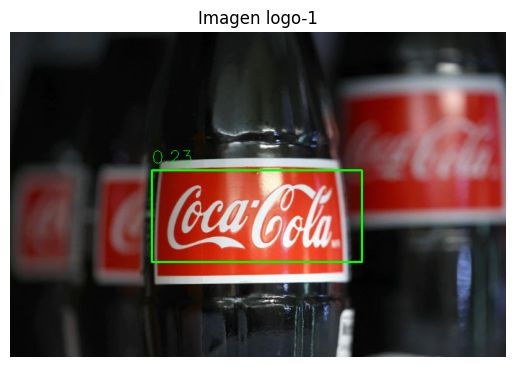

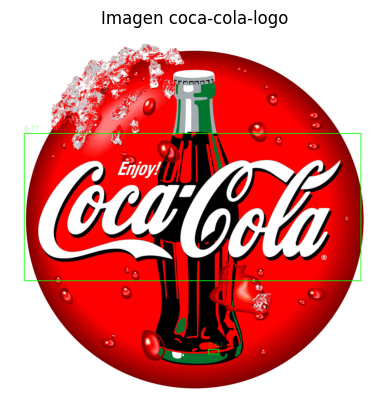

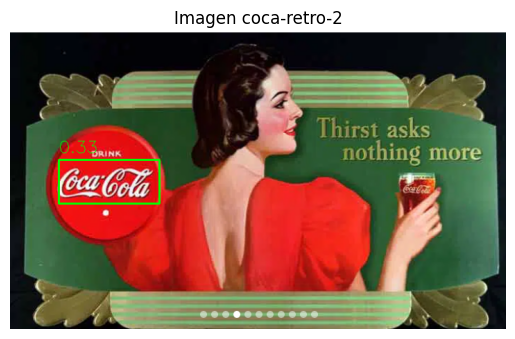

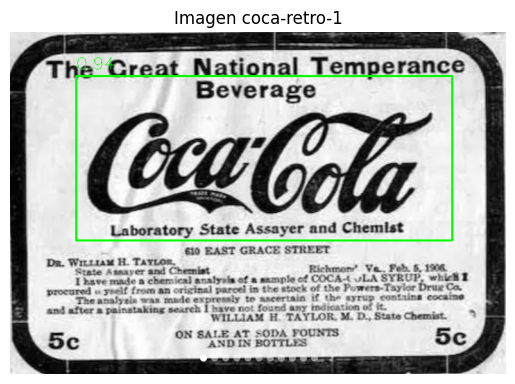

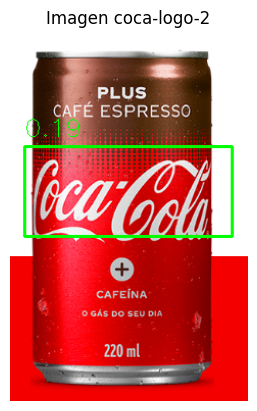

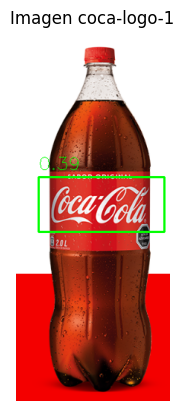

In [12]:
best_match = None
best_scale = None
best_loc = None
methods = ["cv.TM_CCOEFF_NORMED", "cv.TM_CCORR_NORMED", "cv.TM_SQDIFF_NORMED"]

for image in image_paths:
    source = cv.imread(image["path"], cv.IMREAD_COLOR)
    template = cv.imread(template_path, cv.IMREAD_COLOR)
    
    source_process = process_source_image(
        source, 
        apply_edge=image["apply_edges"]
    )
    template_process = process_template(
        template, 
        apply_edge=image["apply_edges"],
        apply_mask=image["apply_mask"]
    )
    template_height, template_width = template_process.shape
    matches = []
    
    for method in methods:
        met = eval(method)
        #1.1 until now best and 1.2
        # for scale in image["scale_range"]:
        #     print(scale)
        #     for resized in pyramid(template_process, scale=scale):
        #         print(resized)
        #         result = cv.matchTemplate(source_process, resized, met)
        #         # source_copy = source.copy()
        #         # loc = np.where( result >= 0.4)
        #         # h, w = resized.shape[:2]
        #         # for pt in zip(*loc[::-1]):
        #         #     cv.rectangle(source_copy, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
        #         # plt.imshow(source_copy)
        #         # plt.show(0)
            
        # break
        for scale in image["scale_range"]:
            resized_template = cv.resize(template_process, (0, 0), fx=scale, fy=scale)
            resized_height, resized_width = resized_template.shape[:2]
            if resized_height > source_process.shape[0] or resized_width > source_process.shape[1]:
                continue

            result = cv.matchTemplate(source_process, resized_template, met)
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)

            if met in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
                confidence = 1 - min_val
                if confidence >= image["threshold"]:
                    top_left = min_loc
                    bottom_right = (int(top_left[0] + template_width * scale),
                                int(top_left[1] + template_height * scale))
                    matches.append((top_left, bottom_right, confidence, method))
            else:
                if image["has_many_instances"]:
                    loc = np.where( result >= image["threshold"])
                    print(np.where(result >= image["threshold"]))
                    (yCoords, xCoords) = np.where(result >= image["threshold"])
                    source_copy = source.copy()
                    for (x, y) in zip(xCoords, yCoords):
                        cv.rectangle(source_copy, (x, y), (x + resized_width, y + resized_height),(255, 0, 0), 3)
                else:
                    confidence = max_val
                    if confidence >= image["threshold"]:
                        top_left = max_loc
                        bottom_right = (int(top_left[0] + template_width * scale),
                                    int(top_left[1] + template_height * scale))
                        matches.append((top_left, bottom_right, confidence, method))
    boxes = [(top_left[0], top_left[1], bottom_right[0], bottom_right[1]) for top_left, bottom_right, _, method in matches]
    confidences = [confidence for _, _, confidence, _ in matches]
    if image["has_many_instances"]:
        filtered_boxes = boxes        
        filtered_confidences = confidences
    else:
        pass
    filtered_boxes, filtered_confidences = non_max_suppression(boxes, confidences,threshold=image["threshold"])


    matched_image = source.copy()
    for box, confidence in zip(filtered_boxes, filtered_confidences):
        top_left = (int(box[0]), int(box[1]))
        bottom_right = (int(box[2]), int(box[3]))
        cv.rectangle(matched_image, top_left, bottom_right, (0, 255, 0), 2)
        cv.putText(
            matched_image, 
            f"{confidence:.2f}", 
            (top_left[0], top_left[1] - 10), 
            cv.FONT_HERSHEY_SIMPLEX, 
            0.8, 
            (0, 255, 0),
            1
        )

    plt.imshow(cv.cvtColor(matched_image, cv.COLOR_BGR2RGB))
    plt.title(f"Imagen {image['name']}")
    plt.axis('off')
    plt.show()